In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from utils.dataset import VideoDataset, MyConcatDataset
from utils.models import TrackNetV2MSE, TrackNetV2NLL
from utils.training import train_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

%load_ext autoreload
%autoreload 2

cuda


## Dataset

Load dataset

In [2]:
sequence_length = 3
one_output_frame = True

image_size = (360, 640)

dataset_params = dict(image_size=image_size,
                      sigma=5,
                      sequence_length=sequence_length,
                      heatmap_mode='image',
                      one_output_frame=one_output_frame,
                      drop_duplicate_frames=True)

dataset_demo = VideoDataset(root="../datasets/dataset_finales_2020_en/", duplicate_equality_threshold=0.97, **dataset_params)

# add transforms
dataset_params['transform'] = ToTensor()
dataset_params['target_transform'] = ToTensor()

roots = [f'../datasets/dataset_lluis/game{i+1}' for i in range(5)]

# training dataset
dataset_train_list = []
dataset_train_list.append(VideoDataset(root="../datasets/dataset_finales_2020_en/", split='train', duplicate_equality_threshold=0.97, **dataset_params))
for root in roots[:-1]:
    dataset_train_list.append(VideoDataset(root=root, duplicate_equality_threshold=1, **dataset_params))

dataset_train = MyConcatDataset(dataset_train_list)

# validation dataset
dataset_val_list = []
dataset_val_list.append(VideoDataset(root="../datasets/dataset_finales_2020_en/", split='val', duplicate_equality_threshold=0.97, **dataset_params))
for root in roots[-1:]:
    dataset_val_list.append(VideoDataset(root=root, duplicate_equality_threshold=1, **dataset_params))

dataset_val = MyConcatDataset(dataset_val_list)

# test dataset (for now equal to validation dataset)
dataset_test = dataset_val

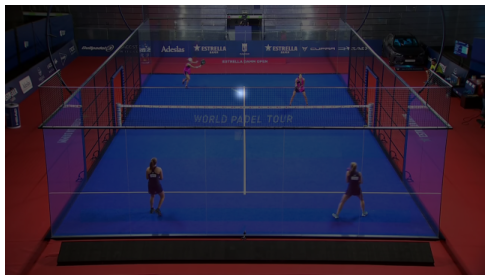

In [3]:
w, h, dpi = 480, 853, 50

fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

frames, labels = dataset_demo[57]
ax.imshow(frames[-1])
ax.imshow(labels, alpha=0.6, cmap='gray')
ax.set_axis_off()
fig.tight_layout(pad=0)

plt.show()

# Training

Load model and set checkpoint folder

In [4]:
model = TrackNetV2MSE(sequence_length=sequence_length, one_output_frame=one_output_frame)
checkpoint_folder = './checkpoints/checkpoints_360_640_mse'

train_model_partial = partial(train_model, loss_function=F.mse_loss)

In [ ]:
model = TrackNetV2NLL(sequence_length=sequence_length)
checkpoint_folder = './checkpoints/checkpoints_360_640_nll'

train_model_partial = partial(train_model, loss_function=F.nll_loss)

## Training loop

In [ ]:
dataset_train.save_info(os.path.join(checkpoint_folder, 'dataset_train_info.json'))
dataset_val.save_info(os.path.join(checkpoint_folder, 'dataset_val_info.json'))

#TODO: check the training recipe
batch_size = 2

# data loaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size)

checkpoint_dict = train_model_partial(model,
                                      data_loader_train,
                                      data_loader_val,
                                      epochs=10,
                                      device=device,
                                      checkpoint_folder=checkpoint_folder,
                                      additional_info={'dataset_train': dataset_train.get_info(),
                                                       'dataset_val': dataset_val.get_info(),
                                                       'dataset_test': dataset_test.get_info()})

Plot train and validation loss

In [ ]:
train_loss = np.loadtxt(os.path.join(checkpoint_folder, "loss_history.csv"))
val_loss = np.loadtxt(os.path.join(checkpoint_folder, "loss_history_val.csv"))

fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(train_loss, label='train loss')
ax.plot(val_loss, label='val loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.legend()

plt.show()

Load weights from checkpoint

In [ ]:
model.to(device)
# model.load("checkpoints\checkpoints_360_640_mse\checkpoint_0007_best.ckpt", device=device)
model.load("checkpoints\checkpoints_360_640_mse\checkpoint_0010.ckpt", device=device)
model.eval();

# Test

## Compute predicted positions

In [ ]:
from utils.testing import compute_positions
from torch.utils.data import Subset

In [ ]:
# s_size = 10
# dataset_test = Subset(dataset_val, np.arange(s_size))
# frames = [frame_num for dataset in dataset_test.dataset.datasets for frame_num in dataset._label_df['num'].values][:s_size]
# dataset_ids = [i for i, dataset in enumerate(dataset_test.dataset.datasets) for j in range(len(dataset))][:s_size]

dataset_test = dataset_val
frames = [frame_num for dataset in dataset_test.datasets for frame_num in dataset._label_df['num'].values]
dataset_ids = [i for i, dataset in enumerate(dataset_test.datasets) for j in range(len(dataset))]

data_loader_test = DataLoader(dataset_test, batch_size=4)
true_positions, predicted_positions, min_values, max_values = compute_positions(model, data_loader_test, device=device, heatmaps_folder='heatmaps')

df_out = pd.DataFrame({'dataset_id': dataset_ids,
                       'frame_num': frames,
                       'min_values': min_values,
                       'max_values': max_values,
                       'x_true': true_positions[:,0]/image_size[1],
                       'y_true': true_positions[:,1]/image_size[0],
                       'x_pred': predicted_positions[:,0]/image_size[1],
                       'y_pred': predicted_positions[:,1]/image_size[0]})

df_out.to_csv(os.path.join(checkpoint_folder, 'val_output.csv'), index=False)

## Analyze error

In [ ]:
df_out = pd.read_csv(os.path.join(checkpoint_folder, 'val_output.csv'))

error = np.sqrt((image_size[1]*(df_out['x_true']-df_out['x_pred']))**2 + (image_size[0]*(df_out['y_true']-df_out['y_pred']))**2)
error = np.asarray(error)

In [ ]:
threshold = 5
print(f"Error smaller than {threshold} pixels: {100*len(np.nonzero(error<=threshold)[0])/len(error):.2g}%")

hist_range = 15
plt.hist(error.clip(max=hist_range), bins=np.arange(hist_range+1), density=True, align='left', rwidth=0.8)
plt.show()

# Show example

Get maximum of the heatmap

In [ ]:
from utils.testing import get_maximum_coordinates

Produce output heatmap

In [ ]:
frame_id = 56

frames, heatmaps = dataset_val[frame_id]
heatmaps_np = heatmaps.numpy()
frames_np = frames.numpy()[-3:].transpose(1, 2, 0)

with torch.no_grad():
    outputs = model(frames[None, :].to(device))
outputs_np = outputs.to('cpu').numpy()[0].transpose(0, 1, 2)

In [ ]:
w, h, dpi = 1280, 720, 150

fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)

ax.imshow(frames_np)

ax.imshow(outputs_np[0], cmap='magma', alpha=0.5)
ax.scatter(*get_maximum_coordinates(heatmaps_np[0]), color='w', label='True position', alpha=0.8)
ax.scatter(*get_maximum_coordinates(outputs_np[0]), color='y', label='Predicted position', alpha=0.8)

ax.legend(framealpha=0.5)

ax.set_axis_off()

fig.tight_layout(pad=0)
fig.savefig("boh.png")

plt.show()

In [ ]:
w, h, dpi = 1280, 720*2, 100

fig, axs = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi, nrows=2)

axs[0].imshow(frames_np)

axs[1].imshow(outputs_np[0], cmap='magma')
axs[1].scatter(*get_maximum_coordinates(heatmaps_np[0]), color='w', label='True position')
axs[1].scatter(*get_maximum_coordinates(outputs_np[0]), color='y', label='Predicted position')

axs[1].legend(framealpha=0.5)

fig.tight_layout()
for ax in axs:
    ax.set_axis_off()

plt.show()

# Duplicate frames demo

In [ ]:
import cv2
root = "../videos/dataset_finales_2020_en/"
cap = cv2.VideoCapture(os.path.join(root, "video.mp4"))

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 13620)
_, frame1 = cap.read()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

_, frame2 = cap.read()
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(frame1)
plt.show()

plt.imshow(frame2)
plt.show()

In [ ]:
plt.imshow(np.abs(frame2 - frame1))
plt.colorbar()
plt.show()

# Modify additional info for old runs

In [ ]:
from utils.storage import load_checkpoint_dict, save_checkpoint

In [ ]:
#d = load_checkpoint_dict('checkpoints/checkpoints_512_3f_mse')
d = load_checkpoint_dict('checkpoints/checkpoints_360_640_mse')

In [ ]:
additional_info = d['additional_info']

In [ ]:
additional_info['dataset_train'] = additional_info_train
additional_info['dataset_val'] = additional_info_val

In [ ]:
save_checkpoint(d, 'checkpoints/checkpoints_512_3f_mse')